In [1]:
from collections import defaultdict, Counter
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import upsetplot as upsp

In [2]:
font = {'family' : 'sans',
        'size'   : 24}
mpl.rc('font', **font)
dpi = 300

## Data load

In [3]:
gisaid_vcf_data = pd.read_csv("Data/gisaid_all_041820_complete_and_simulated_SNV.vcf", 
                              sep='\t', header=0, index_col=False)

gisaid_variants = {}
for seq in gisaid_vcf_data.columns[9:]:
    if "GISAID" in seq:
        gisaid_variants[seq] = []
        
for i, row in gisaid_vcf_data.iterrows():
    pos = row["POS"]
    ref = row["REF"]
    vs  = row["ALT"].split(",")
    for seq in gisaid_vcf_data.columns[9:]:
        if "GISAID" in seq:
            vtype = row[seq]
            if vtype != 0:
                gisaid_variants[seq].append((pos, ref, vs[vtype - 1], 1.0))
                
gisaid_variants_no_N = {}
for seq in gisaid_variants:
    gisaid_variants_no_N[seq] = list(filter(lambda x: x[2] != 'N', gisaid_variants[seq])) 
    
gisaid_data_no_N = {}
for sample in gisaid_variants_no_N:
    gisaid_data_no_N[sample] = defaultdict(float)
    for variant in gisaid_variants_no_N[sample]:
        pos, ref, var, af = variant
        gisaid_data_no_N[sample][(pos, ref, var)] = af

In [4]:
mason_variants = {} 
for filepath in glob.iglob('Data/SNV_calling_lowfreq_v2_0.02_reduced/*.vcf'):
    filename = filepath.split("/")[2][:-4]
    mason_variants[filename] = []
    mason_vcf = pd.read_csv(filepath, sep='\t', header=0, index_col=False)
    for i, row in mason_vcf.iterrows():
        pos = row["POS"]
        ref = row["REF"]
        vs  = row["ALT"]
        af  = row["INFO"]
        mason_variants[filename].append((pos,ref,vs,af))
        
mason_data = {}
for sample in mason_variants:
    mason_data[sample] = defaultdict(float)
    for variant in mason_variants[sample]:
        pos, ref, var, af = variant
        mason_data[sample][(pos, ref, var)] = af

In [5]:
baylor_variants = {}
for filepath in glob.iglob('Data/baylor_data_0.02_reduced/*.vcf'):
    filename = filepath.split("/")[2][:-4]
    baylor_variants[filename] = []
    baylor_vcf = pd.read_csv(filepath, sep='\t', header=0, index_col=False)
    for i, row in baylor_vcf.iterrows():
        pos = row["POS"]
        ref = row["REF"]
        vs  = row["ALT"]
        af  = row["INFO"]
        baylor_variants[filename].append((pos,ref,vs,af))
        
baylor_data = {}
for sample in baylor_variants:
    baylor_data[sample] = defaultdict(float)
    for variant in baylor_variants[sample]:
        pos, ref, var, af = variant
        baylor_data[sample][(pos, ref, var)] = af

In [6]:
mers_variants = {} 
for filepath in glob.iglob('MERS/vcf_files_lofreq_0.02_reduced/*.vcf'):
    filename = filepath.split("/")[2][:-4]
    mers_variants[filename] = []
    mers_vcf = pd.read_csv(filepath, sep='\t', header=0, index_col=False)
    for i, row in mers_vcf.iterrows():
        pos = row["POS"]
        ref = row["REF"]
        vs  = row["ALT"]
        af  = row["INFO"]
        mers_variants[filename].append((pos,ref,vs,af))
        
mers_variants_set = set()
for sample in mers_variants:
    for v in mers_variants[sample]:
        mers_variants_set.add((v[0], v[1], v[2]))

In [7]:
sars_variants = {} 
for filepath in glob.iglob('SARS/vcf_files_lofreq_0.02_reduced/*.vcf'):
    filename = filepath.split("/")[2][:-4]
    sars_variants[filename] = []
    sars_vcf = pd.read_csv(filepath, sep='\t', header=0, index_col=False)
    for i, row in sars_vcf.iterrows():
        pos = row["POS"]
        ref = row["REF"]
        vs  = row["ALT"]
        af  = row["INFO"]
        sars_variants[filename].append((pos,ref,vs,af))
        
sars_variants_set = set()
for sample in sars_variants:
    for v in sars_variants[sample]:
        sars_variants_set.add((v[0], v[1], v[2]))

In [8]:
rna_variants = {} 
for filepath in glob.iglob('PRJNA608224/vcf_files_lofreq_0.02_reduced/*.vcf'):
    filename = filepath.split("/")[2][:-4]
    rna_variants[filename] = []
    rna_vcf = pd.read_csv(filepath, sep='\t', header=0, index_col=False)
    for i, row in rna_vcf.iterrows():
        pos = row["POS"]
        ref = row["REF"]
        vs  = row["ALT"]
        af  = row["INFO"]
        rna_variants[filename].append((pos,ref,vs,af))
        
rna_variants_set = set()
for sample in rna_variants:
    for v in rna_variants[sample]:
        rna_variants_set.add((v[0], v[1], v[2]))

In [9]:
baylor_variants_no_freq = {sample: [(v[0], v[1], v[2]) for v in baylor_variants[sample]] 
                           for sample in baylor_variants}

mason_variants_no_freq = {sample: [(v[0], v[1], v[2]) for v in mason_variants[sample]] 
                          for sample in mason_variants}

gisaid_variants_no_freq = {sample: [(v[0], v[1], v[2]) for v in gisaid_variants_no_N[sample]] 
                           for sample in gisaid_variants_no_N}

baylor_variants_list = []
for sample in baylor_variants_no_freq:
    baylor_variants_list += baylor_variants_no_freq[sample]
baylor_variants_set = set(baylor_variants_list)

mason_variants_list = []
for sample in mason_variants_no_freq:
    mason_variants_list += mason_variants_no_freq[sample]
mason_variants_set = set(mason_variants_list)

gisaid_variants_list = []
for sample in gisaid_variants_no_freq:
    gisaid_variants_list += gisaid_variants_no_freq[sample]
gisaid_variants_set = set(gisaid_variants_list)

In [10]:
protein_positions = {"5_UTR": (1, 265), "NSP1": (266, 805), "NSP2": (806, 2719), "NSP3": (2720, 8554),
                     "NSP4": (8555, 10054), "NSP5": (10055, 10972), "NSP6": (10973, 11842), "NSP7": (11843, 12091),
                     "NSP8": (12092, 12685), "NSP9": (12686, 13024), "NSP10": (13025, 13441), "NSP11": (13442, 13480),
                     "NSP12": (13468, 16236), "NSP13": (16237, 18039), "NSP14": (18040, 19620),
                     "NSP15": (19621, 20658), "NSP16": (20659, 21552), "S": (21563, 25384), "ORF3a": (25393, 26220),
                     "E": (26245, 26472), "M": (26523, 27191), "ORF6": (27202, 27387), "ORF7a": (27394, 27759),
                     "ORF7b": (27756, 27887), "ORF8": (27894, 28259), "N": (28274, 29533), "ORF10": (29558, 29674),
                     "3_UTR": (29675, 29903)}

In [11]:
gisaid_variants_set_protein = {protein: [] for protein in protein_positions}
for variant in gisaid_variants_set:
    position = variant[0]
    for protein in protein_positions:
        if (protein_positions[protein][0] < position) and (position < protein_positions[protein][1]):
            gisaid_variants_set_protein[protein].append(variant)
            
mason_variants_set_protein = {protein: [] for protein in protein_positions}
for variant in mason_variants_set:
    position = variant[0]
    for protein in protein_positions:
        if (protein_positions[protein][0] < position) and (position < protein_positions[protein][1]):
            mason_variants_set_protein[protein].append(variant)
            
baylor_variants_set_protein = {protein: [] for protein in protein_positions}
for variant in baylor_variants_set:
    position = variant[0]
    for protein in protein_positions:
        if (protein_positions[protein][0] < position) and (position < protein_positions[protein][1]):
            baylor_variants_set_protein[protein].append(variant)

## Figure 2

### Subfigure A

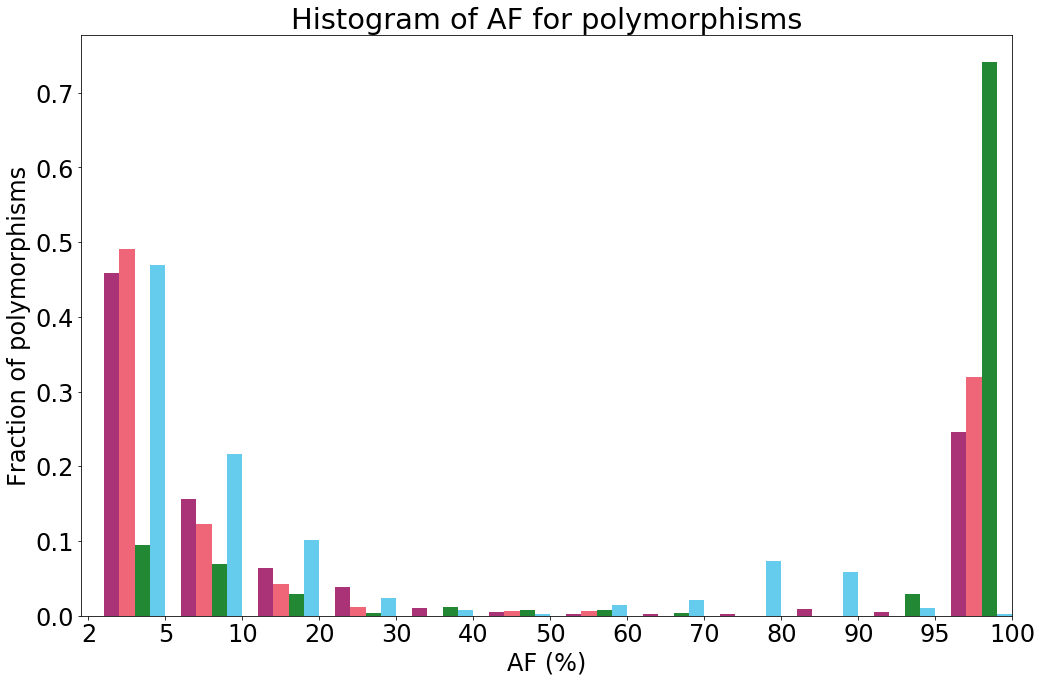

In [26]:
plt.figure(figsize=(15,10))
plt.title("Histogram of AF for polymorphisms")
msvsaf = []
bsvsaf = []
ssvsaf = []
mrsvsaf = []
for sample in mason_variants:
    for variant in mason_variants[sample]:
        msvsaf.append(variant[3])
for sample in baylor_variants:
    for variant in baylor_variants[sample]:
        bsvsaf.append(variant[3])
for sample in mers_variants:
    for variant in mers_variants[sample]:
        mrsvsaf.append(variant[3])
for sample in sars_variants:
    for variant in sars_variants[sample]:
        ssvsaf.append(variant[3])
bins=[0., .02, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1.]
heights_mason, e_mason = np.histogram(msvsaf, bins=bins,
                                      weights=[1. / len(msvsaf) for i in range(len(msvsaf))])
heights_baylor, e_baylor = np.histogram(bsvsaf, bins=bins,
                                        weights=[1. / len(bsvsaf) for i in range(len(bsvsaf))])
heights_sars, e_sars = np.histogram(ssvsaf, bins=bins,
                                    weights=[1. / len(ssvsaf) for i in range(len(ssvsaf))])
heights_mers, e_mers = np.histogram(mrsvsaf, bins=bins,
                                    weights=[1. / len(mrsvsaf) for i in range(len(mrsvsaf))])
plt.bar(np.arange(len(bins) - 1) - 3 * .2, heights_mason, color="#aa3377", width = 0.2)
plt.bar(np.arange(len(bins) - 1) - 2 * .2, heights_baylor, color="#ee6677", width = 0.2)
plt.bar(np.arange(len(bins) - 1) - 1 * .2, heights_sars, color="#228833", width = 0.2)
plt.bar(np.arange(len(bins) - 1), heights_mers, color="#66ccee", width = 0.2)
plt.ylabel("Fraction of polymorphisms")
plt.xlabel("AF (%)")
plt.xticks(np.arange(len(bins) - 1) + .1, 
           labels=["2", "5", "10", "20", "30", "40", "50", "60", "70", "80", "90", "95", "100"])
plt.xlim((0,len(bins)-1.9))
plt.tight_layout()
plt.savefig(f"Figures/Figure-2A-dpi{dpi}.png", dpi=dpi)
plt.show()

### Subfigure B

In [13]:
snv_groups_dir = [["A", "T"], ["A", "C"], ["A", "G"],
                  ["C", "T"], ["C", "G"], ["G", "T"],
                  ["T", "A"], ["C", "A"], ["G", "A"],
                  ["T", "C"], ["G", "C"], ["T", "G"],]

In [14]:
gisaid_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in gisaid_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            gisaid_variants_by_group_dir[i].add(variant)
            
baylor_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in baylor_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            baylor_variants_by_group_dir[i].add(variant)
            
mason_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in mason_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            mason_variants_by_group_dir[i].add(variant)
            
rna_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in rna_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            rna_variants_by_group_dir[i].add(variant)

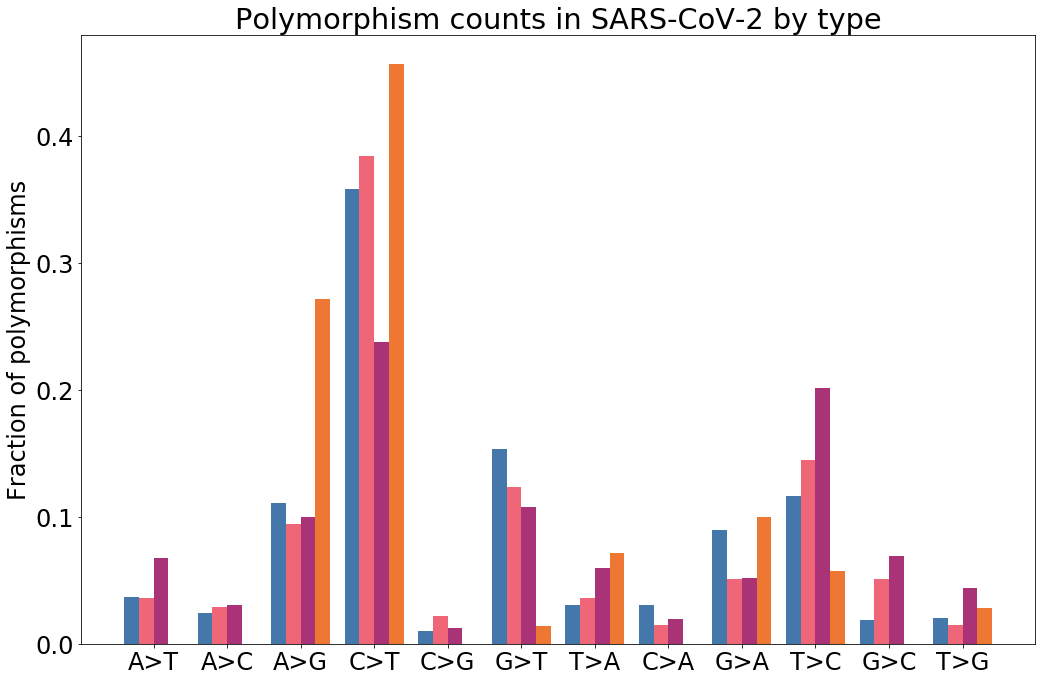

In [27]:
plt.figure(figsize=(15,10))
plt.title("Polymorphism counts in SARS-CoV-2 by type")
plt.bar(np.arange(12) - 2 * .15, np.asarray([len(vs) for vs in gisaid_variants_by_group_dir]) / sum([len(vs) for vs in gisaid_variants_by_group_dir]),
        color="#4477AA", width=0.20)
plt.bar(np.arange(12) - 1 * .1, np.asarray([len(vs) for vs in baylor_variants_by_group_dir]) / sum([len(vs) for vs in baylor_variants_by_group_dir]), 
        color="#ee6677", width=0.20)
plt.bar(np.arange(12) + 1 * .1, np.asarray([len(vs) for vs in mason_variants_by_group_dir]) / sum([len(vs) for vs in mason_variants_by_group_dir]), 
        color="#aa3377", width=0.20)
plt.bar(np.arange(12) + 2 * .15, np.asarray([len(vs) for vs in rna_variants_by_group_dir]) / sum([len(vs) for vs in rna_variants_by_group_dir]), 
        color="#ee7733", width=0.20)
plt.xticks(np.arange(12), labels=[f"{group[0]}>{group[1]}" for group in snv_groups_dir])
plt.ylabel("Fraction of polymorphisms")
plt.tight_layout()
plt.savefig(f"Figures/Figure-2B-dpi{dpi}.png", dpi=dpi)
plt.show()

### Subfigure C

In [16]:
sars2_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in gisaid_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            sars2_variants_by_group_dir[i].add(variant)
            
for i, group in enumerate(snv_groups_dir):
    for variant in baylor_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            sars2_variants_by_group_dir[i].add(variant)
            
for i, group in enumerate(snv_groups_dir):
    for variant in mason_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            sars2_variants_by_group_dir[i].add(variant)
            
for i, group in enumerate(snv_groups_dir):
    for variant in rna_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            sars2_variants_by_group_dir[i].add(variant)
            
sars_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in sars_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            sars_variants_by_group_dir[i].add(variant)
            
mers_variants_by_group_dir = [set() for g in snv_groups_dir]
for i, group in enumerate(snv_groups_dir):
    for variant in mers_variants_set:
        if (variant[1] == group[0]) and (variant[2] == group[1]):
            mers_variants_by_group_dir[i].add(variant)

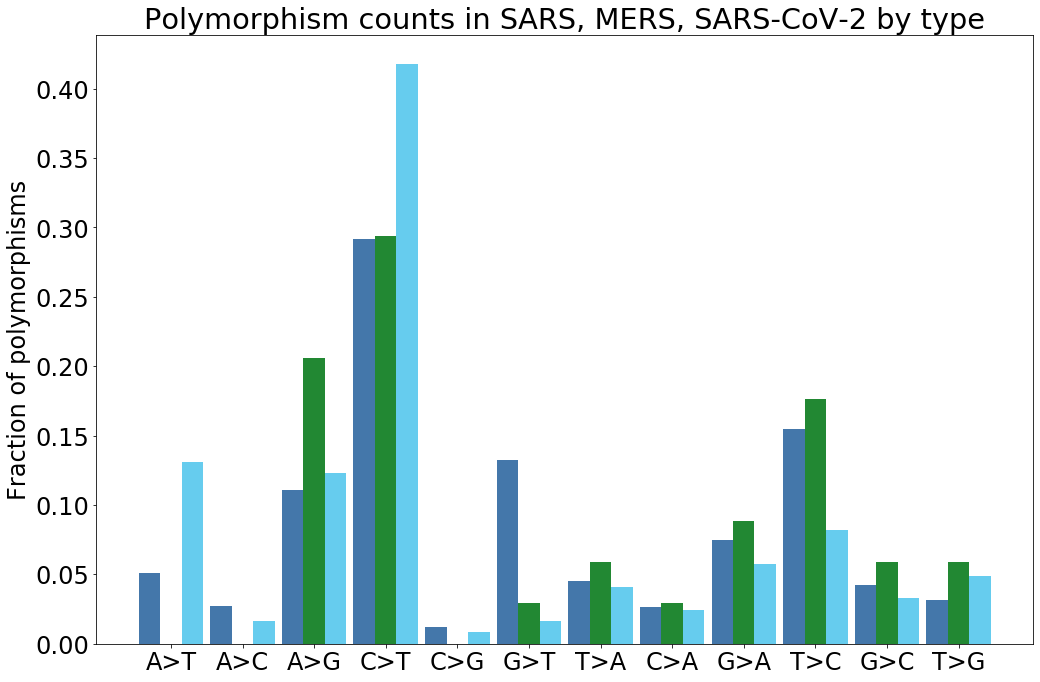

In [25]:
plt.figure(figsize=(15,10))
plt.title("Polymorphism counts in SARS, MERS, SARS-CoV-2 by type")
plt.bar(np.arange(12) - 1 * .3, np.asarray([len(vs) for vs in sars2_variants_by_group_dir]) / sum([len(vs) for vs in sars2_variants_by_group_dir]),
        color="#4477AA", width=0.30)
plt.bar(np.arange(12), np.asarray([len(vs) for vs in sars_variants_by_group_dir]) / sum([len(vs) for vs in sars_variants_by_group_dir]), 
        color="#228833", width=0.30)
plt.bar(np.arange(12) + 1 * .3, np.asarray([len(vs) for vs in mers_variants_by_group_dir]) / sum([len(vs) for vs in mers_variants_by_group_dir]), 
        color="#66ccee", width=0.30)
plt.xticks(np.arange(12), labels=[f"{group[0]}>{group[1]}" for group in snv_groups_dir])
plt.ylabel("Fraction of polymorphisms")
plt.tight_layout()
plt.savefig(f"Figures/Figure-2C-dpi{dpi}.png", dpi=dpi)
plt.show()

### Subfigure D

In [18]:
gisaid_variants_by_group_protein = {protein: [set() for g in snv_groups_dir] for protein in gisaid_variants_set_protein}
for protein in gisaid_variants_set_protein:
    for i, group in enumerate(snv_groups_dir):
        for variant in gisaid_variants_set_protein[protein]:
            if (variant[1] == group[0]) and (variant[2] == group[1]):
                gisaid_variants_by_group_protein[protein][i].add(variant)
                
mason_variants_by_group_protein = {protein: [set() for g in snv_groups_dir] for protein in mason_variants_set_protein}
for protein in mason_variants_set_protein:
    for i, group in enumerate(snv_groups_dir):
        for variant in mason_variants_set_protein[protein]:
            if (variant[1] == group[0]) and (variant[2] == group[1]):
                mason_variants_by_group_protein[protein][i].add(variant)
                
baylor_variants_by_group_protein = {protein: [set() for g in snv_groups_dir] for protein in baylor_variants_set_protein}
for protein in baylor_variants_set_protein:
    for i, group in enumerate(snv_groups_dir):
        for variant in baylor_variants_set_protein[protein]:
            if (variant[1] == group[0]) and (variant[2] == group[1]):
                baylor_variants_by_group_protein[protein][i].add(variant)

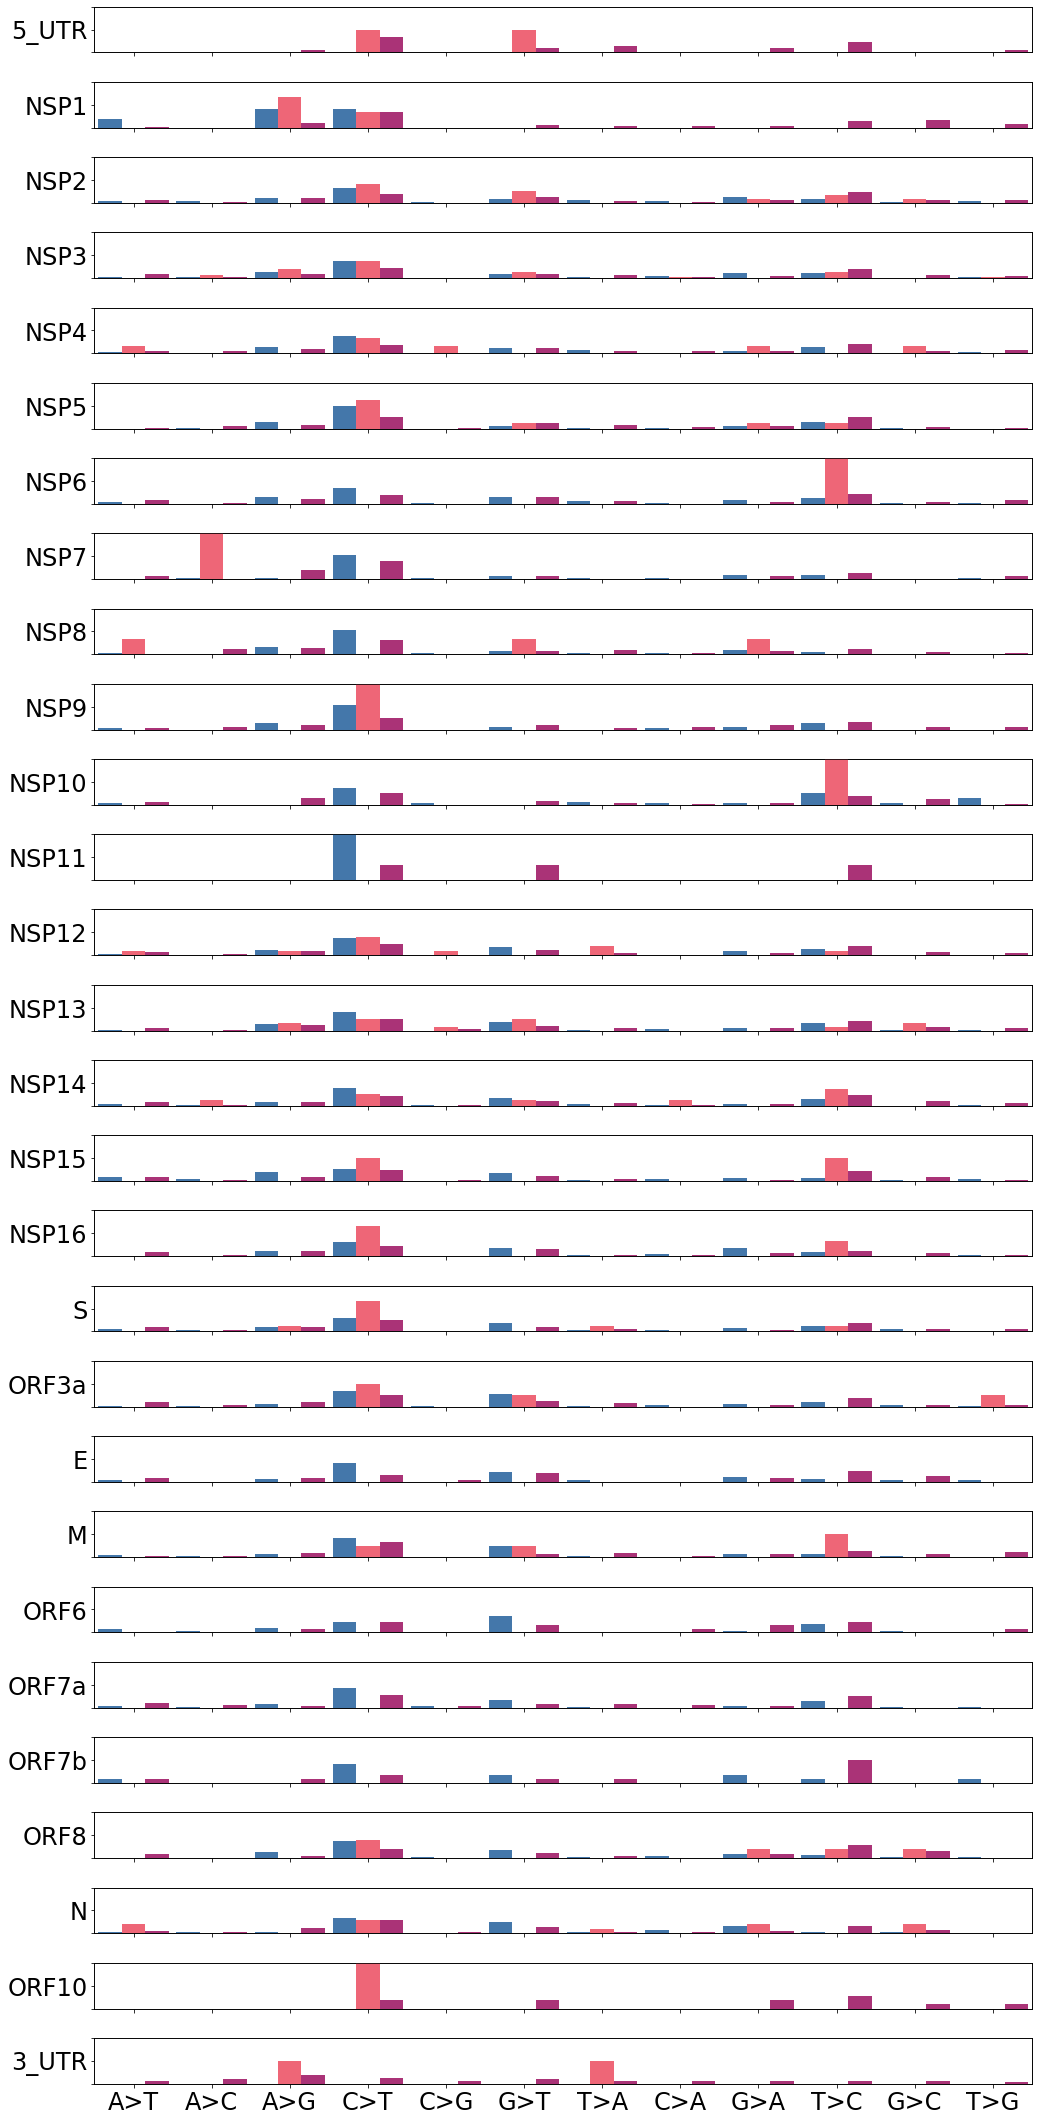

In [19]:
fig, axs = plt.subplots(28, 1, figsize=(15,30))
for k, protein in enumerate(protein_positions):
    axs[k].set_ylim((0,1))
    axs[k].set_yticks([0,.5,1.])
    axs[k].set_yticklabels(["",f"{protein}",""])
    axs[k].yaxis.tick_right()
    axs[k] = axs[k].twinx()
    len_gisaid_vs_by_group = [len(vs) for vs in gisaid_variants_by_group_protein[protein]]
    sum_gisaid_vs_by_group = sum(len_gisaid_vs_by_group)
    len_mason_vs_by_group = [len(vs) for vs in mason_variants_by_group_protein[protein]]
    sum_mason_vs_by_group = sum(len_mason_vs_by_group)
    len_baylor_vs_by_group = [len(vs) for vs in baylor_variants_by_group_protein[protein]]
    sum_baylor_vs_by_group = sum(len_baylor_vs_by_group)

    if sum_gisaid_vs_by_group != 0:
        axs[k].bar(np.arange(12) - 0.3, [float(l) / sum_gisaid_vs_by_group for l in len_gisaid_vs_by_group], 
                      color="#4477AA", width=0.3)
    if sum_mason_vs_by_group != 0:
        axs[k].bar(np.arange(12) + 0.3, [float(l) / sum_mason_vs_by_group for l in len_mason_vs_by_group],
                      color="#aa3377", width=0.3)
    if sum_baylor_vs_by_group != 0:
        axs[k].bar(np.arange(12), [float(l) / sum_baylor_vs_by_group for l in len_baylor_vs_by_group], 
                      color="#ee6677", width=0.3)
    axs[k].set_xticks(np.arange(12))
    axs[k].set_xticklabels([])
    axs[k].set_xlim((-.5,11.5))
    axs[k].set_ylim((0,1))
    axs[k].get_xaxis().set_visible(False)
    axs[k].set_yticks([])

axs[27].set_xticks(np.arange(12))
axs[27].set_xticklabels([f"{group[0]}>{group[1]}" for group in snv_groups_dir])
axs[27].set_xlim((-.5,11.5))

fig.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.savefig(f"Figures/Figure-2D-dpi{dpi}.png", dpi=dpi)
plt.show()

## Figure 3

In [20]:
baylor_lf_variants_no_freq = {sample: [] for sample in baylor_variants}
for sample in baylor_variants:
    for v in baylor_variants[sample]:
        if v[3] < 0.5:
            baylor_lf_variants_no_freq[sample].append((v[0], v[1], v[2]))
            
mason_lf_variants_no_freq = {sample: [] for sample in mason_variants}
for sample in mason_variants:
    for v in mason_variants[sample]:
        if v[3] < 0.5:
            mason_lf_variants_no_freq[sample].append((v[0], v[1], v[2]))
            
baylor_lf_variants_list = []
for sample in baylor_lf_variants_no_freq:
    baylor_lf_variants_list += baylor_lf_variants_no_freq[sample]
baylor_lf_variants_set = set(baylor_lf_variants_list)

mason_lf_variants_list = []
for sample in mason_lf_variants_no_freq:
    mason_lf_variants_list += mason_lf_variants_no_freq[sample]
mason_lf_variants_set = set(mason_lf_variants_list)

In [21]:
mason_mixed_variants_set = set()
for sample in mason_variants:
    for variant in mason_variants[sample]:
        if ((variant[0], variant[1], variant[2]) in mason_lf_variants_set) and \
            variant[3] >= 0.5:
            mason_mixed_variants_set.add((variant[0], variant[1], variant[2]))
            
baylor_mixed_variants_set = set()
for sample in baylor_variants:
    for variant in baylor_variants[sample]:
        if ((variant[0], variant[1], variant[2]) in baylor_lf_variants_set) and \
            variant[3] >= 0.5:
            baylor_mixed_variants_set.add((variant[0], variant[1], variant[2]))
            
mason_strict_lf_variants_set = mason_lf_variants_set - mason_mixed_variants_set
baylor_strict_lf_variants_set = baylor_lf_variants_set - baylor_mixed_variants_set

In [22]:
shared_all = gisaid_variants_set & mason_variants_set & baylor_variants_set
shared_baylor_gisaid = gisaid_variants_set & baylor_variants_set
shared_baylor_mason = mason_variants_set & baylor_variants_set
shared_mason_gisaid = gisaid_variants_set & mason_variants_set
shared_strict_lf_all = gisaid_variants_set & mason_strict_lf_variants_set & baylor_strict_lf_variants_set
shared_strict_lf_baylor_gisaid = gisaid_variants_set & baylor_strict_lf_variants_set
shared_strict_lf_baylor_mason = mason_strict_lf_variants_set & baylor_strict_lf_variants_set
shared_strict_lf_mason_gisaid = gisaid_variants_set & mason_strict_lf_variants_set
shared_strict_lf_all_merged = gisaid_variants_set & (mason_strict_lf_variants_set | baylor_strict_lf_variants_set)

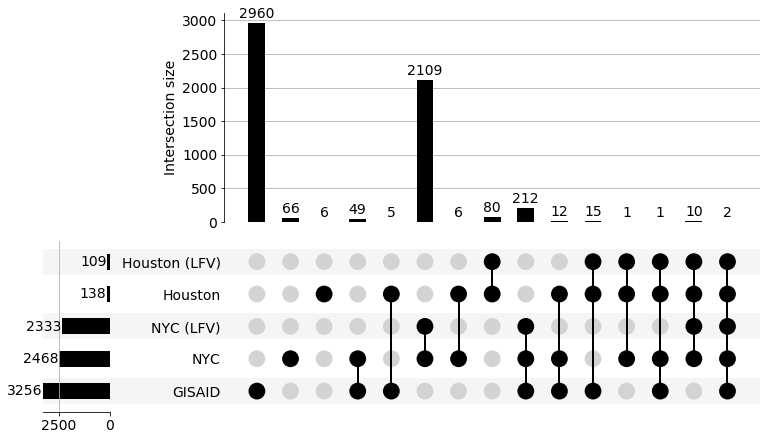

In [28]:
membership = [["Houston"], ["Houston (< 50% AF only)"], ["NYC"], ["NYC (< 50% AF only)"], ["GISAID"], ["Houston + NYC"],
              ["Houston", "NYC"], ["Houston", "GISAID"], ["NYC", "GISAID"], ["Houston", "NYC", "GISAID"], ["Houston + NYC", "GISAID"],
              ["Houston (< 50% AF only)", "NYC (< 50% AF only)"], 
              ["Houston + NYC (< 50% AF only)"],
              ["Houston (< 50% AF only)", "GISAID"], ["NYC (< 50% AF only)", "GISAID"], 
              ["Houston (< 50% AF only)", "NYC (< 50% AF only)", "GISAID"],
              ["Houston + NYC (< 50% AF only)", "GISAID"]]
data = [len(baylor_variants_set), len(baylor_strict_lf_variants_set),
        len(mason_variants_set), len(mason_strict_lf_variants_set),
        len(gisaid_variants_set), len(baylor_variants_set | mason_variants_set),
        len(shared_baylor_mason), len(shared_baylor_gisaid), len(shared_mason_gisaid), len(shared_all),
        len(baylor_variants_set | mason_variants_set & gisaid_variants_set),
        len(shared_strict_lf_baylor_mason), len(mason_strict_lf_variants_set | baylor_strict_lf_variants_set),
        len(shared_strict_lf_baylor_gisaid), len(shared_strict_lf_mason_gisaid),
        len(shared_strict_lf_all), len(shared_strict_lf_all_merged)
       ]
contents = {"Houston": list(map(str, baylor_variants_set)),
            "NYC": list(map(str, mason_variants_set)), 
            "Houston (LFV)": list(map(str, baylor_strict_lf_variants_set)),
            "NYC (LFV)": list(map(str, mason_strict_lf_variants_set)),
            "GISAID": list(map(str, gisaid_variants_set)),
           }
font = {'family' : 'sans',
        'size'   : 14}
mpl.rc('font', **font)
fig, ax = plt.subplots(figsize=(15,8))
ax.axis('off')
upsetplot_data = upsp.from_contents(contents)
upsp.plot(upsetplot_data, fig=fig, show_counts='%d', sum_over=False, element_size=48)
plt.savefig(f"Figures/Figure-3-dpi{dpi}.png", dpi=dpi)
plt.show()

font = {'family' : 'sans',
        'size'   : 24}
mpl.rc('font', **font)

## Supplementary figures

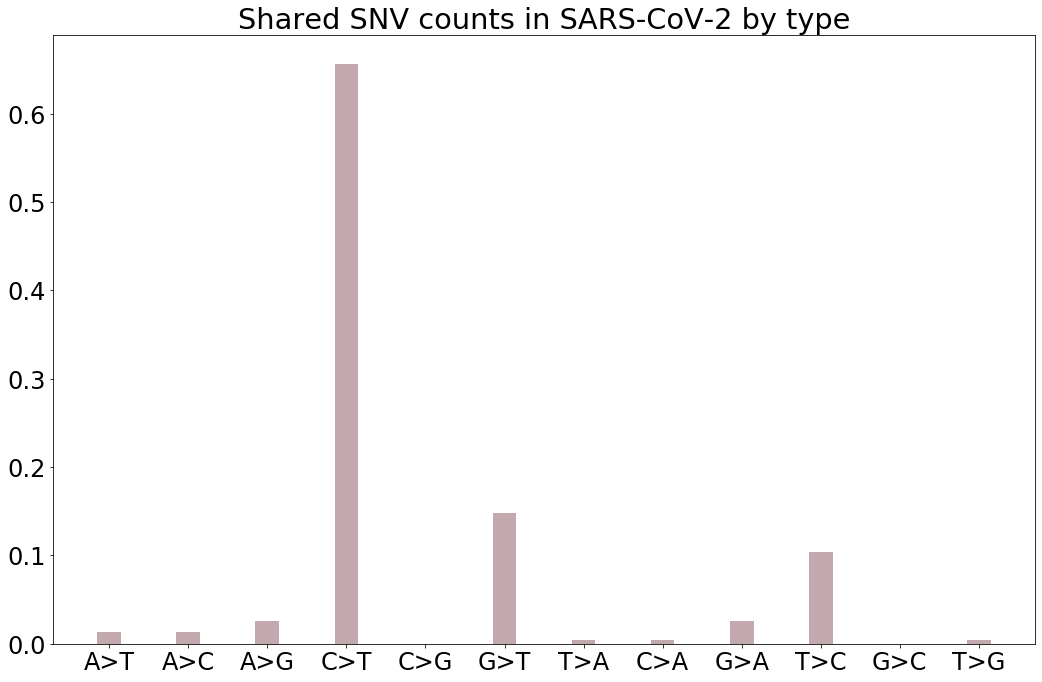

In [26]:
plt.figure(figsize=(15,10))
plt.title("Shared SNV counts in SARS-CoV-2 by type")
plt.bar(np.arange(12), np.asarray([len(vs) for vs in shared_variants_by_group_dir]) / sum([len(vs) for vs in shared_variants_by_group_dir]), 
        tick_label=[f"{group[0]}>{group[1]}" for group in snv_groups_dir],
        color="#88555E", width=0.30, alpha=.5)
plt.tight_layout()
plt.savefig(f"Figures/sars-cov-2-sahred-snv-type-dir-frac-dpi{dpi}.png", dpi=dpi)
plt.show()